<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/NN%20ECG%20LSTM%20CNN%20Attention%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim import Adam
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

ссылка на первоисточник данных ЭКГ:

https://www.physionet.org/content/mitdb/1.0.0/

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

# Make dataset

In [184]:
#подключаем гугл-диск для загрузки датасета
from google.colab import drive
drive.mount('/content/drive')
file_path_train = '/content/drive/MyDrive/edf_process/mitbih_train.csv'
file_path_test = '/content/drive/MyDrive/edf_process/mitbih_test.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [202]:
#датасет большой, поэтому сформируем случайным образом тренировочный датасет
import random

n = 100000 #number of records in file
s = 10000 #desired sample size
skip = sorted(random.sample(range(n),n-s))

df_mitbih_train = pd.read_csv(file_path_train, header=None, skiprows=skip)
df_mitbih_test = pd.read_csv(file_path_test, header=None, skiprows=skip)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

In [203]:
# датасет размечен на 5 классов
# в исходном датасете столбец №187 содержит номер класса
df_mitbih.rename(columns={187: 'class'}, inplace=True)

df_mitbih_test.rename(columns={187: 'class'}, inplace=True)
df_mitbih_train.rename(columns={187: 'class'}, inplace=True)

In [204]:
# добавим текстовое описание к размеченным классам
id_to_label = {
    0: "Normal",     #0: "Нормальный"
    1: "Artial Premature", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Premature ventricular contraction", # "Преждевременное сокращение желудочков"
    3: "Fusion of ventricular and normal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Fusion of paced and normal" #"Cлияние стимулированного и нормального ритма"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
df_mitbih_test['label'] = df_mitbih_test.iloc[:, -1].map(id_to_label)
df_mitbih_train['label'] = df_mitbih_train.iloc[:, -1].map(id_to_label)


print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10933 entries, 0 to 2157
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 15.8+ MB
None


In [205]:
# упростим задачу - переходим к бинарной классификации - назначаем норму и ненорму на классы
id_to_label = {
    0: "Normal",     #0: "условно-здоровый"
    1: "Abnormal", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Abnormal", # "Преждевременное сокращение желудочков"
    3: "Abnormal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Abnormal" #"Cлияние стимулированного и нормального ритма"
}
df_mitbih['healthy_status'] = df_mitbih.iloc[:, -2].map(id_to_label)
df_mitbih_test['healthy_status'] = df_mitbih_test.iloc[:, -2].map(id_to_label)
df_mitbih_train['healthy_status'] = df_mitbih_train.iloc[:, -2].map(id_to_label)


print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10933 entries, 0 to 2157
Columns: 190 entries, 0 to healthy_status
dtypes: float64(188), object(2)
memory usage: 15.9+ MB
None


In [208]:
#классы несбалансированы
df_mitbih_train['class'].value_counts()

,count
class,
0.0,7324
4.0,595
2.0,584
1.0,217
3.0,55


In [210]:
#создаем процедуру перемешивания данных и их балансировки
from sklearn.utils import shuffle
df_mitbih_test = shuffle(df_mitbih_test)
df_mitbih_train = shuffle(df_mitbih_train)

df_mitbih_test = df_mitbih_test.reset_index(drop='True')
df_mitbih_train = df_mitbih_train.reset_index(drop='True')

#df_mitbih_test.to_csv('/content/comp_ECG_fast_checkup_test.csv')
#df_mitbih_train.to_csv('/content/comp_ECG_fast_checkup_train.csv')

In [215]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,class,label,healthy_status
0,1.000000,0.846535,0.371287,0.000000,0.165842,0.169554,0.108911,0.107673,0.117574,0.117574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Normal
1,0.471698,1.000000,0.867925,0.000000,0.056604,0.364780,0.415094,0.415094,0.415094,0.459119,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Normal
2,0.987868,0.989601,0.419411,0.000000,0.161179,0.310225,0.299827,0.275563,0.284229,0.284229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Normal
3,1.000000,0.763359,0.124682,0.096692,0.058524,0.025445,0.040712,0.025445,0.025445,0.096692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Normal
4,1.000000,0.769042,0.130221,0.164619,0.113022,0.063882,0.085995,0.066339,0.071253,0.142506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Normal


In [227]:
from imblearn.under_sampling import RandomUnderSampler

# Создание экземпляра RandomUnderSampler
#rus_method = RandomUnderSampler(sampling_strategy='majority')
rus_method = RandomUnderSampler()

df = df_mitbih_train
#df = df_mitbih.loc[:, df_mitbih.columns != 'healthy_status']

# Применение уменьшения выборки к данным
df.columns = df.columns.astype(str)
X_resampled, y_resampled = rus_method.fit_resample(df, df['class'])

new_df =pd.concat([X_resampled, y_resampled])

#не забываем удалить NaN
new_df = new_df.dropna()
new_df['class'].value_counts()
#получаем взвешенную выборку

,count
class,
0.0,55
1.0,55
2.0,55
3.0,55
4.0,55


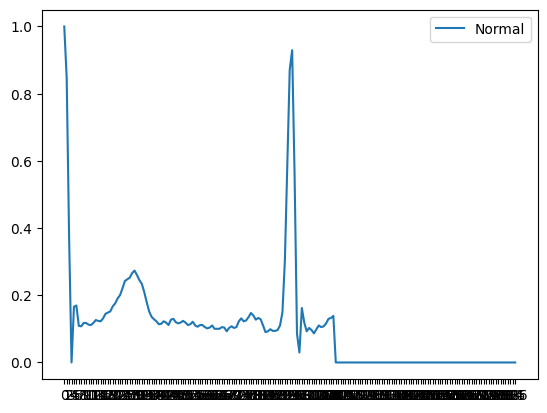

In [229]:
# пример как выглядит кардиограмма из датасета
plt.plot(df_mitbih_train.iloc[0][:-3], label=str(df_mitbih_train.iloc[0]['label']))
plt.legend()
plt.show()

In [233]:
#проверяем, что нет больше значений NaN
check_nan = new_df.isnull().values.any()
print(check_nan)

False


# Class data loader

In [234]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-3].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

In [235]:
#def get_dataloader(df, phase: str, batch_size: int = 96) -> DataLoader:
def get_dataloader(df, phase: str, batch_size: int = 96):

    '''
    Dataset and DataLoader.
    Parameters:
        pahse: training or validation phase.
        batch_size: data per iteration.
    Returns:
        data generator
    '''
    #df = pd.read_csv(config.train_csv_path)
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=123, stratify=df['label']
    )
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4)
    return dataloader

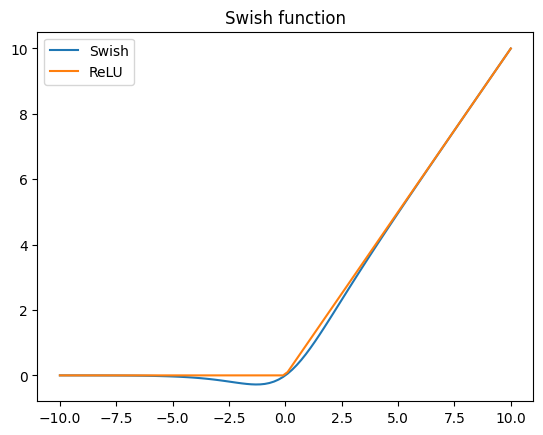

In [236]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.show()

# NN Models

In [237]:
class RNN(nn.Module):
    """RNN module(cell type lstm or gru)"""
    def __init__(
        self,
        input_size,
        hid_size,
        num_rnn_layers=1,
        dropout_p = 0.2,
        bidirectional = False,
        rnn_type = 'lstm',
    ):
        super().__init__()

        if rnn_type == 'lstm':
            self.rnn_layer = nn.LSTM(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )

        else:
            self.rnn_layer = nn.GRU(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )
    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

In [238]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size = 1,
        hid_size = 256,
        kernel_size = 5,
        num_classes = 5,
    ):

        super().__init__()

        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size//2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size//2,
            hidden_size=hid_size//4,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size//4, out_features=num_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        # print(x.shape) # num_features * num_channels
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)
        return x

In [239]:
class ConvNormPool(nn.Module):
    """Conv Skip-connection module"""
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

In [240]:
class RNNModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,#hid_size * 2 if bidirectional else hid_size,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x, _ = self.rnn_layer(x)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)#.squeeze(1)
        return x

In [241]:
class RNNAttentionModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

In [242]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion

In [243]:
class Trainer:
    def __init__(self, df, net, lr, batch_size, num_epochs):
        #self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        #self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.optimizer = AdamW(net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(df, phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()

    def _train_epoch(self, phase, net):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        #self.net.train() if phase == 'train' else self.net.eval()
        net.train() if phase == 'train' else net.eval()
        meter = Meter()
        meter.init_metrics()

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            target = target.to(device)
            #data = data.to(config.device)
            #target = target.to(config.device)

            #output = self.net(data)
            output = net(data)
            loss = self.criterion(output, target)

            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            meter.update(output, target, loss.item())

        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()

        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
             )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss

    def run(self, net):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train',net=net)
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val',net=net)
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                #torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
                torch.save(net.state_dict(), f"best_model_epoc{epoch}.pth")
            #clear_output()


# Modeling

In [248]:
#создаем модель нейронной сети

#model = RNNAttentionModel(1, 64, 'lstm', bidirectional=False)
#model = RNNModel(input_size=1, hid_size=64, rnn_type='lstm', bidirectional=True)
model = CNN(num_classes=5, hid_size=64)

In [247]:
#model._modules.items()
#model.state_dict()

train mode | time: 15:54:09


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

loss: 1.7691383021218436, accuracy: 0.6170634920634921, f1: 0.54443651954709, precision: 0.6641981034838178, recall: 0.7505703819989534


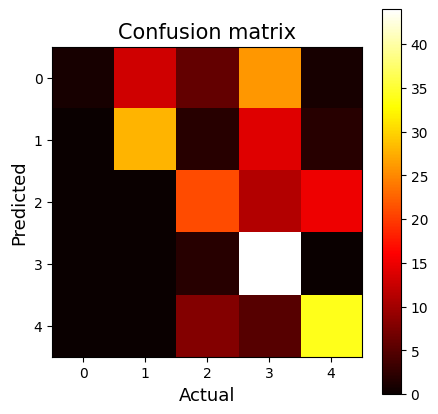

val mode | time: 15:54:11


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 3.2167062759399414, accuracy: 0.35, f1: 0.11636363636363636, precision: 0.4, recall: 1.67


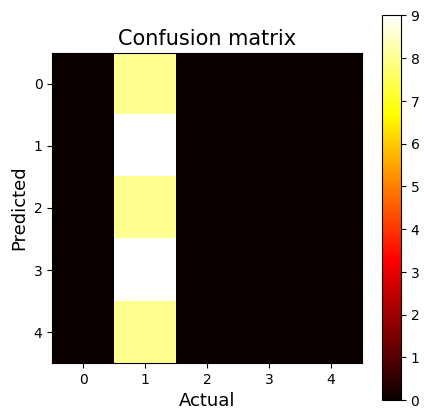


New checkpoint

train mode | time: 15:54:12


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.7259777614048548, accuracy: 0.6840277777777778, f1: 0.5984280458648285, precision: 0.7323613687899402, recall: 0.8081658817373103


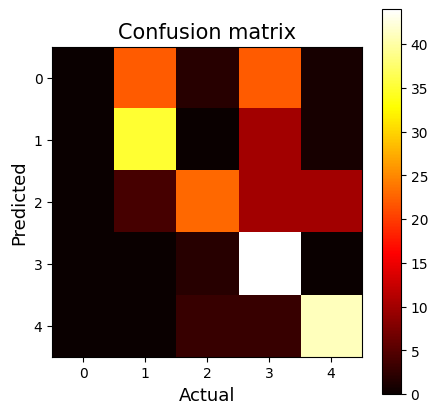

val mode | time: 15:54:15


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 3.209383487701416, accuracy: 0.35, f1: 0.11636363636363636, precision: 0.4, recall: 1.67


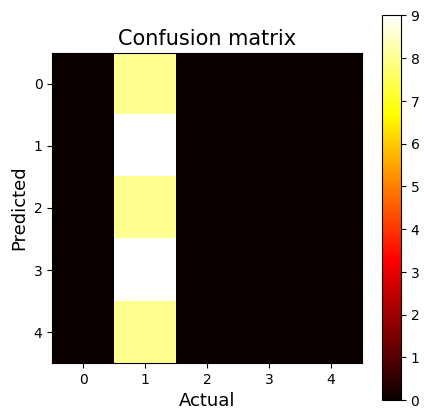


New checkpoint

train mode | time: 15:54:16


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.6840600286211287, accuracy: 0.7242063492063492, f1: 0.6399041810320006, precision: 0.7713440527726242, recall: 0.8479602143887858


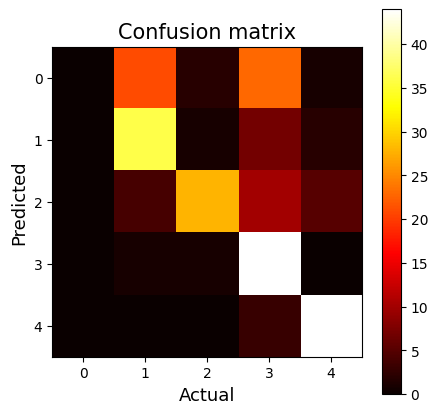

val mode | time: 15:54:17


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 3.1924253702163696, accuracy: 0.44375, f1: 0.23411764705882354, precision: 0.5, recall: 1.3837606837606837


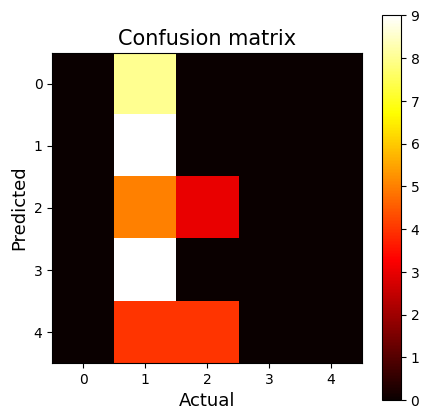


New checkpoint

train mode | time: 15:54:18


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.6451185090201241, accuracy: 0.7847222222222222, f1: 0.6994859803816018, precision: 0.8232271696557412, recall: 0.8865625644197073


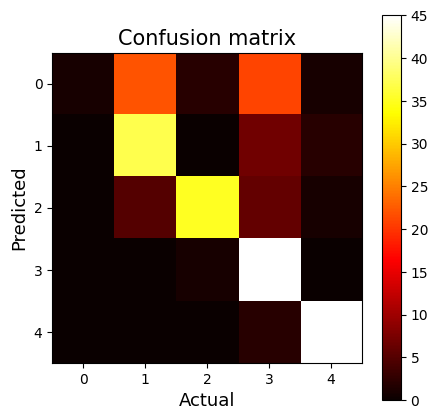

val mode | time: 15:54:19


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 3.1727073192596436, accuracy: 0.7375, f1: 0.6903686635944701, precision: 0.6771428571428573, recall: 1.416231884057971


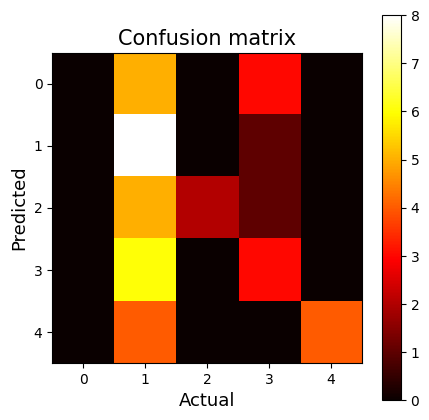


New checkpoint

train mode | time: 15:54:20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.611096637589591, accuracy: 0.8293650793650793, f1: 0.7497287353169707, precision: 0.8594310451453309, recall: 0.906185322613894


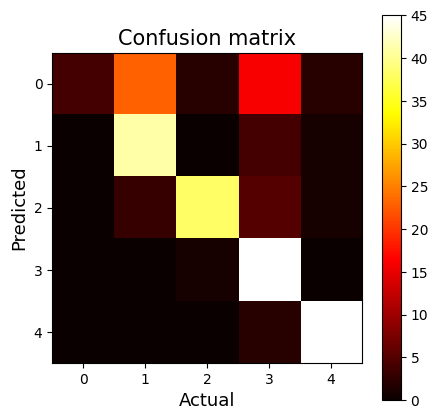

val mode | time: 15:54:21


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 3.1015926599502563, accuracy: 0.9625, f1: 0.846157059314954, precision: 0.9033333333333333, recall: 1.2224242424242422


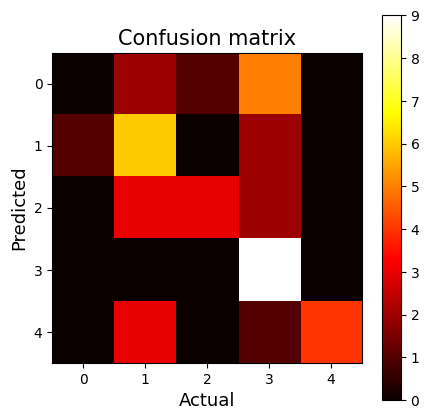


New checkpoint

train mode | time: 15:54:22


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.585058603967939, accuracy: 0.8204365079365079, f1: 0.7293073826267104, precision: 0.8517326324469182, recall: 0.9089053803339517


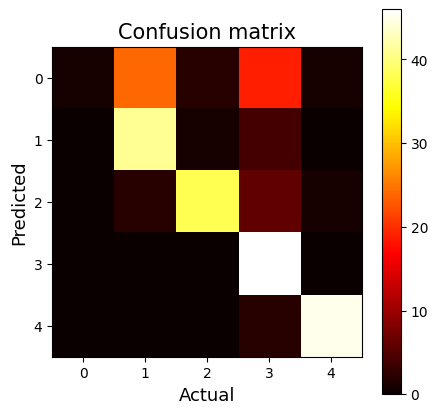

val mode | time: 15:54:23


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 3.0331984758377075, accuracy: 1.1625, f1: 0.9494235375309543, precision: 1.0366666666666666, recall: 1.2341666666666664


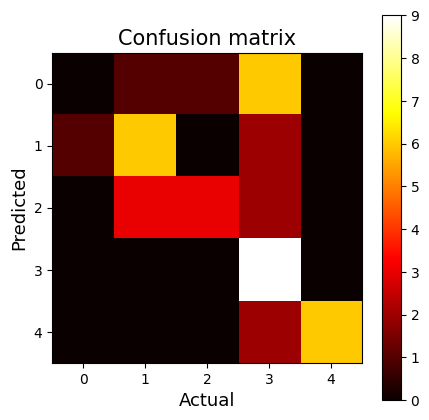


New checkpoint

train mode | time: 15:54:24


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.5639256409236364, accuracy: 0.8472222222222222, f1: 0.7672760246289657, precision: 0.8787507730364873, recall: 0.9299379192236333


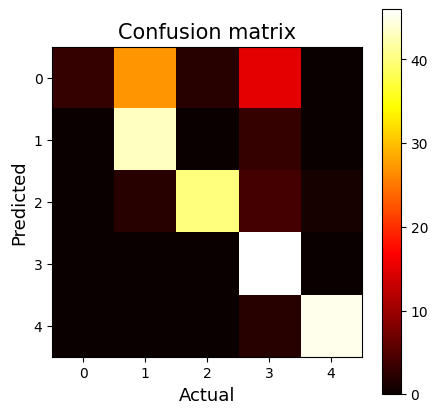

val mode | time: 15:54:25


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 2.9330310821533203, accuracy: 1.225, f1: 1.0382251082251082, precision: 1.1033333333333333, recall: 1.3447619047619046


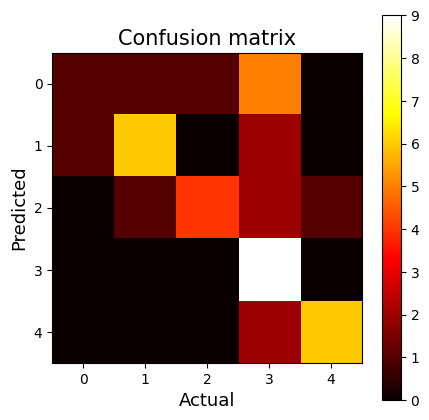


New checkpoint

train mode | time: 15:54:26


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.5517267840249198, accuracy: 0.8427579365079365, f1: 0.7565099699553481, precision: 0.8730364873222015, recall: 0.9270364556078841


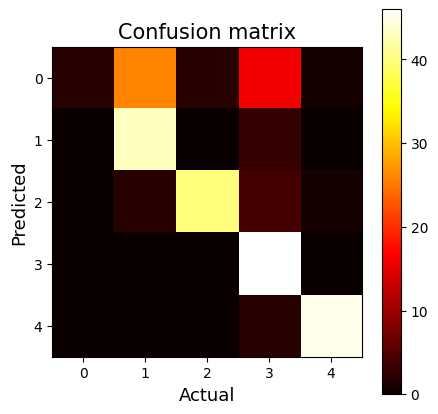

val mode | time: 15:54:28


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 2.8666439056396484, accuracy: 1.19375, f1: 0.9448917748917748, precision: 1.07, recall: 1.3233333333333333


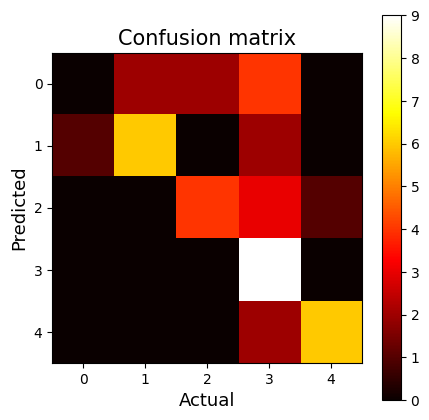


New checkpoint

train mode | time: 15:54:29


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.543694257736206, accuracy: 0.8472222222222222, f1: 0.7607016466260165, precision: 0.8787507730364873, recall: 0.9309480202337345


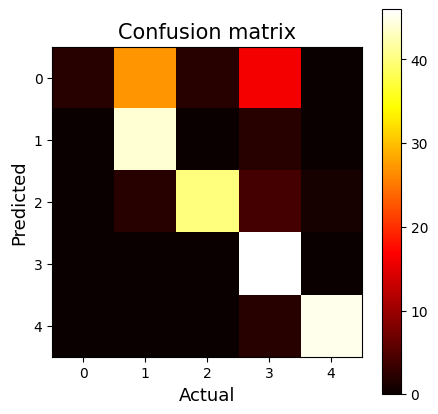

val mode | time: 15:54:31


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 2.812220335006714, accuracy: 1.19375, f1: 0.9448917748917748, precision: 1.07, recall: 1.3233333333333333


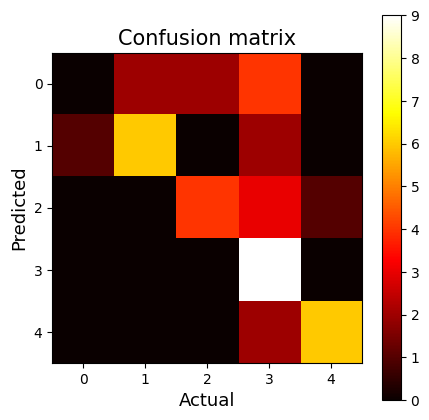


New checkpoint

train mode | time: 15:54:32


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 1.5402751479830061, accuracy: 0.8472222222222222, f1: 0.7607016466260165, precision: 0.8787507730364873, recall: 0.9309480202337345


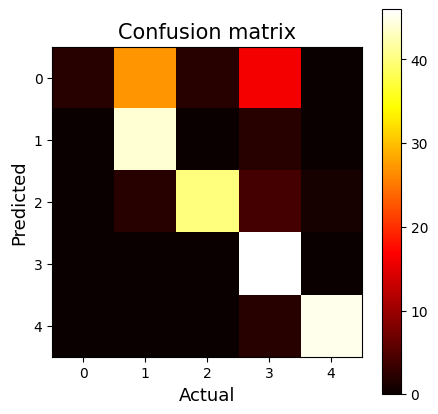

val mode | time: 15:54:33


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


loss: 2.775261163711548, accuracy: 1.19375, f1: 0.9448917748917748, precision: 1.07, recall: 1.3233333333333333


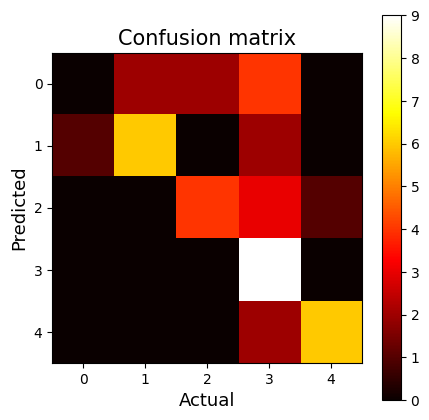


New checkpoint



In [256]:
#запускаем обучение нейронной сети

#trainer = Trainer(df=df_mitbih, net=model, lr=1e-3, batch_size=32, num_epochs=1)
trainer = Trainer(df=new_df, net=model, lr=1e-3, batch_size=32, num_epochs=10)
trainer.run(net=model)

In [174]:
#model.eval()

CNN(
  (conv1): ConvNormPool(
    (conv_1): Conv1d(1, 64, kernel_size=(5,), stride=(1,))
    (conv_2): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
    (conv_3): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
    (swish_1): Swish()
    (swish_2): Swish()
    (swish_3): Swish()
    (normalization_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (normalization_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (normalization_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvNormPool(
    (conv_1): Conv1d(64, 32, kernel_size=(5,), stride=(1,))
    (conv_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (conv_3): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (swish_1): Swish()
    (swish_2): Swish()
    (swish_3): Swish()
    (normalization_1): BatchNorm1d(32, eps=1e-05

In [257]:
train_logs = trainer.train_df_logs
train_logs.columns = ["train_"+ colname for colname in train_logs.columns]
val_logs = trainer.val_df_logs
val_logs.columns = ["val_"+ colname for colname in val_logs.columns]

logs = pd.concat([train_logs,val_logs], axis=1)
logs.reset_index(drop=True, inplace=True)
logs = logs.loc[:, [
    'train_loss', 'val_loss',
    'train_accuracy', 'val_accuracy',
    'train_f1', 'val_f1',
    'train_precision', 'val_precision',
    'train_recall', 'val_recall']
                                 ]
logs.head()

,train_loss,val_loss,train_accuracy,val_accuracy,train_f1,val_f1,train_precision,val_precision,train_recall,val_recall
0,1.769138,3.216706,0.617063,0.35000,0.544437,0.116364,0.664198,0.400000,0.750570,1.670000
1,1.725978,3.209383,0.684028,0.35000,0.598428,0.116364,0.732361,0.400000,0.808166,1.670000
2,1.684060,3.192425,0.724206,0.44375,0.639904,0.234118,0.771344,0.500000,0.847960,1.383761
3,1.645119,3.172707,0.784722,0.73750,0.699486,0.690369,0.823227,0.677143,0.886563,1.416232
4,1.611097,3.101593,0.829365,0.96250,0.749729,0.846157,0.859431,0.903333,0.906185,1.222424


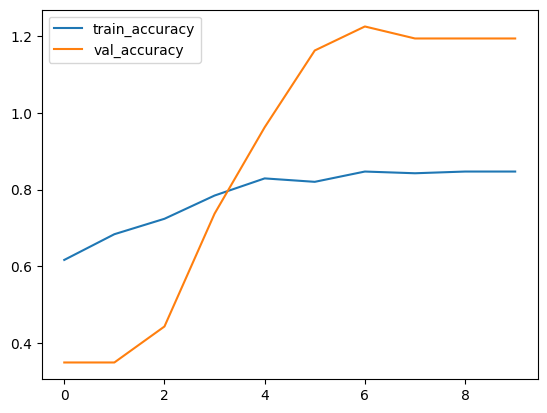

In [258]:
plt.plot(logs["train_accuracy"], label='train_accuracy')
plt.plot(logs["val_accuracy"], label='val_accuracy' )
plt.legend()
plt.show()

In [259]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)

            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)

            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    return predictions_cls, ground_truths_cls

In [260]:
#test_dataset = ECGDataset(df_mitbih_test)
test_dataset = ECGDataset(df_mitbih_test)
print(df_mitbih_test.shape)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, num_workers=0, shuffle=False)

(2158, 190)


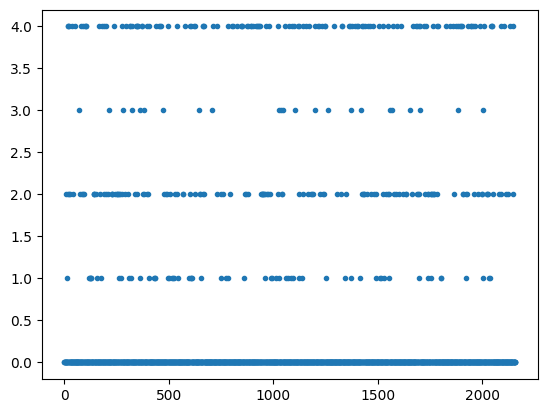

In [266]:
#смотрим сколько данных класса в тестовом дата-сете
plt.plot(test_dataset[:][1],'.')

In [267]:
#заготовка для сравнения разных моделей

#models = [cnn_model, lstm_model, attn_model]
models = [model]

#рассчитываем значение выхода нейронной сети по тестовым данным
y_pred, y_true = make_test_stage(test_dataloader, models[0])
y_pred.shape, y_true.shape

((2158,), (2158,))

In [268]:
id_to_label = {
    0: "Normal",     #0: "Нормальный"
    1: "Artial Premature", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Premature ventricular contraction", # "Преждевременное сокращение желудочков"
    3: "Fusion of ventricular and normal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Fusion of paced and normal" #"Cлияние стимулированного и нормального ритма"
}

In [271]:
# упростим задачу - переходим к бинарной классификации - назначаем норму и ненорму на классы
id_to_label = {
    0: "Normal",     #0: "условно-здоровый"
    1: "Abnormal", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Abnormal", # "Преждевременное сокращение желудочков"
    3: "Abnormal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Abnormal" #"Cлияние стимулированного и нормального ритма"
}

Text(0.5, 1.0, 'Ensemble Classification Report')

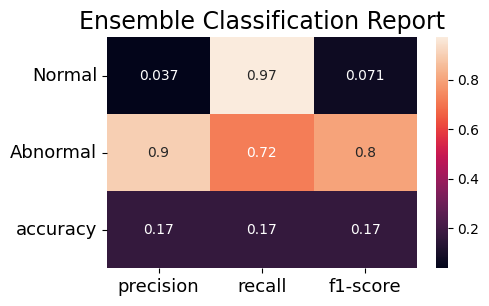

In [272]:
clf_report = classification_report(y_pred,
                                   y_true,
                                   labels=[0,1,2,3,4],
                                   target_names=list(id_to_label.values()),
                                   output_dict=True)


plt.figure(figsize=(5, 3))
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-2].T, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=13)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=13, rotation=0)
plt.title("Ensemble Classification Report", fontsize=17)

#plt.savefig(f"ensemble result.svg",format="svg",bbox_inches='tight', pad_inches=0.2)
#plt.savefig(f"ensemble result.png", format="png",bbox_inches='tight', pad_inches=0.2)